In [1]:
%install_ext https://raw.github.com/cpcloud/ipython-autotime/master/autotime.py
%load_ext autotime
import re
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

Installed autotime.py. To use it, type:
  %load_ext autotime


In [2]:
df = pd.read_csv('full_output2.csv')
db = pd.read_csv('dbp/train.csv')

time: 3.94 s


In [3]:
names = ['class', 'title', 'wiki']
d = {}
for i, c in enumerate(db.columns):
    d[c] = names[i]

db = db.rename(columns=d)

time: 104 ms


In [4]:
df = df[df.wiki != 'nan']

# unicode
df.wiki = df.wiki.map(lambda x: re.sub(r'[^\x00-\x7F]','',str(x)))
db.wiki = db.wiki.map(lambda x: re.sub(r'[^\x00-\x7F]','',str(x)))

# stopwords
pattern = re.compile(r'\b(' + r'|'.join(stopwords.words('english')) + r')\b\s*')
df['wiki'] = df.wiki.apply(lambda x: pattern.sub('', x))
db['wiki'] = db.wiki.apply(lambda x: pattern.sub('', x))

time: 40.4 s


In [5]:
df.head(1)

,Best Entity literalString,wiki,Entity,cls
0,Psychogenic pruritus,Psychogenic pruritus common manifestation chro...,psychogenic_pruritus,0


time: 12.8 ms


In [6]:
del df['Entity']
names = ['title', 'wiki', 'class']
d = {}
for i, c in enumerate(df.columns):
    d[c] = names[i]

df = df.rename(columns=d)

time: 3.07 ms


In [7]:
df['wiki'] = df.wiki.apply(lambda x: x.lower().strip())
db['wiki'] = db.wiki.apply(lambda x: x.lower().strip())

df['class'] = df['class'].apply(lambda x: np.int64(x))
db['class'] = db['class'].apply(lambda x: np.int64(x))

time: 2.48 s


In [8]:
db = db.drop_duplicates('wiki')
db = db[pd.notnull(db['wiki'])]
df = df.drop_duplicates('wiki')
df = df[pd.notnull(df['wiki'])]

time: 477 ms


In [9]:
len(db)

559875

time: 1.84 ms


In [10]:
db = db[0:1734]

time: 1.29 ms


In [11]:
len(df)

1734

time: 1.69 ms


In [12]:
conc = pd.concat([df, db])

time: 6.56 ms


In [13]:
conc.head()

,class,title,wiki
0,0,Psychogenic pruritus,psychogenic pruritus common manifestation chro...
1,0,Hydrophthalmos,hydrophthalmos congenital form glaucoma.
2,0,Amino acid transport disorder,amino acid transport disorders medical conditi...
3,0,Adelaide Hanscom,adelaide hanscom leeson (25 november 1875 19 ...
4,0,trachoma,trachoma also called granular conjunctivitis e...


time: 10.5 ms


In [14]:
del df['title']

time: 1.16 ms


In [15]:
conc.to_csv('final_join.csv', index=False)

time: 28.5 ms


In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression as LR
from sklearn.feature_extraction.text import TfidfVectorizer

tr_data = conc

trX = tr_data['wiki'].values
trY = tr_data['class'].values

vect = TfidfVectorizer(min_df=10, ngram_range=(1, 2))

trX = vect.fit_transform(trX)


model = LR()
model.fit(trX, trY)

print model.predict_proba(vect.transform(['this is great']))

[[ 0.72108476  0.27891524]]
time: 1.4 s


In [17]:
coef = model.coef_.ravel()

pos = np.argsort(coef)[-20:]
neg = np.argsort(coef)[:20]
tops = np.hstack([neg, pos])
f_names = np.array(vect.get_feature_names())

f_names[tops]

array([u'syndrome', u'disease', u'condition', u'adelaide', u'disorder',
       u'may', u'caused', u'rare', u'characterized', u'form', u'born',
       u'blood', u'skin', u'cells', u'inflammation', u'type', u'usually',
       u'species', u'common', u'congenital', u'the company', u'record',
       u'firm', u'software', u'products', u'new', u'inc', u'largest',
       u'headquartered', u'business', u'corporation', u'airline', u'bank',
       u'owned', u'manufacturer', u'services', u'label', u'based',
       u'founded', u'company'], 
      dtype='<U23')

time: 11.9 ms


In [18]:
d = {'features': f_names[tops], 'vals': tops}

time: 2.77 ms


In [19]:
df = pd.DataFrame(d)

time: 2.24 ms


In [20]:
df.to_csv('feature_importance.csv', index=False)

time: 15.1 ms


In [21]:
tops

array([1923,  638,  502,  120,  644, 1257,  367, 1634,  395,  843,  304,
        291, 1816,  374, 1029, 2032, 2067, 1852,  455,  508, 1959, 1657,
        815, 1829, 1585, 1366,  999, 1140,  933,  334,  538,  145,  254,
       1451, 1241, 1776, 1131,  259,  853,  466])

time: 21.4 ms


In [22]:
def visualize_coefficients(classifier, feature_names, n_top_features=25):
    # get coefficients with large absolute values 
    coef = classifier.coef_.ravel()
    positive_coefficients = np.argsort(coef)[-n_top_features:]
    negative_coefficients = np.argsort(coef)[:n_top_features]
    interesting_coefficients = np.hstack([negative_coefficients, positive_coefficients])
    # plot them
    plt.figure(figsize=(15, 5))
    colors = ["red" if c < 0 else "blue" for c in coef[interesting_coefficients]]
    plt.bar(np.arange(2 * n_top_features), coef[interesting_coefficients], color=colors)
    feature_names = np.array(feature_names)
    plt.xticks(np.arange(1, 1 + 2 * n_top_features), feature_names[interesting_coefficients], rotation=60, ha="right");

time: 7.3 ms


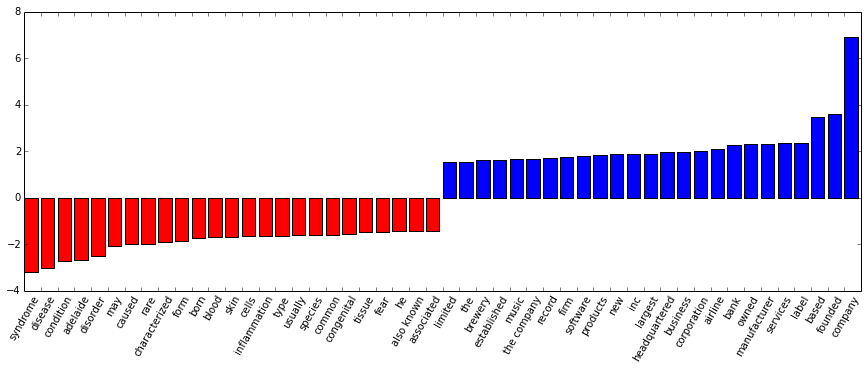

time: 919 ms


In [23]:
visualize_coefficients(model, vect.get_feature_names())

In [24]:
import pickle
output = open('model.pkl', 'wb')
pickle.dump(model, output)
output.close()

time: 8.37 ms


In [25]:
pkl_file = open('model.pkl', 'rb')
model = pickle.load(pkl_file)
pkl_file.close()
model.predict_proba(vect.transform(['this is a syndrome']))

array([[ 0.96153776,  0.03846224]])

time: 17.6 ms
